# This file's purpose is to evaluate the performance of the model on Self-Collected data. It invloves Transforming, Misaligning, Normalising, and Segmenting data, as well as performing predictions.

In [ ]:
# Import libraries

from google.colab import drive
import pandas as pd
import numpy as np
import torch
from torch.optim import Adam
import torch.nn as nn
from collections import defaultdict
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the path to the CSV file in Google Drive
file_path = "/content/drive/My Drive/PROJECT/data_sheets/sensor_data_updated3.csv"  # Self-collected test set

# Load CSV into DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
df.head()

,Unnamed: 0,LArm_ax,LArm_ay,LArm_az,LArm_gx,LArm_gy,LArm_gz,LArm_mx,LArm_my,LArm_mz,...,RArm_ax,RArm_ay,RArm_az,RArm_gx,RArm_gy,RArm_gz,RArm_mx,RArm_my,RArm_mz,labels
0,58,2.059583,-0.744562,-0.604547,135.510687,-9.036641,-40.932061,0.443299,-2.080645,-1.412698,...,1.595813,0.342200,-1.601160,30.458779,-23.514504,-38.459542,-1.023529,-2.840909,-5.307692,4
1,59,2.059583,-0.751154,-0.649957,126.083206,22.665649,-67.183969,0.443299,-2.016129,-1.222222,...,2.163379,0.114172,-1.599695,134.038931,-5.461069,-21.818321,-0.929412,-2.750000,-5.461538,4
2,60,2.059583,-0.412531,-0.713434,82.693893,9.589313,-54.725954,0.257732,-2.032258,-1.317460,...,1.930774,0.375403,-2.003015,70.886260,9.974046,-15.741985,-0.600000,-2.750000,-5.307692,4
3,61,2.059583,-0.104181,-0.780084,17.167176,11.963359,8.083206,0.195876,-2.048387,-1.222222,...,1.384387,0.123694,-2.239832,-9.594656,22.775573,-13.635115,-0.764706,-2.681818,-5.346154,4
4,62,2.059583,0.153387,-0.674615,-50.527481,4.520611,47.670992,0.154639,-2.112903,-1.222222,...,1.363391,0.297766,-2.363611,-48.022137,60.042748,-6.207634,-0.717647,-2.954545,-5.346154,4


In [ ]:
# Define path to the trained model
model_path = "/content/drive/My Drive/PROJECT/Models/CNNLSTM_AUG_54/DCL-3L_Framewise_54_20.pth"

In [ ]:
# trim index out (happened automatically during building a DataFrame)

X_test = np.array(df.iloc[:,1:-1])
y_test = np.array(df.iloc[:,-1])

print(X_test.shape)
print(y_test.shape)

# Transforming Data

In [ ]:
# Function to transform data

def group_activity_chunks(X, y, label_order=[4, 21, 10, 22, 19]):
    """
    Purpose:
        This function takes a sequence of activity data (X) and corresponding labels (y),
        identifies continuous chunks of the same activity, and groups them according to
        a specified label order. It ensures that the resulting dataset is restructured
        so that all activity chunks appear in the desired order, which is useful for
        controlled testing or reordering sequences.

    Args:
        X (array-like): The feature data, typically a time-series signal (e.g., sensor readings).
        y (array-like): The corresponding activity labels.
        label_order (list): A list specifying the desired order of activity labels.

    Returns:
        X_final (np.ndarray): The reordered feature data, grouped by activity chunks.
        y_final (np.ndarray): The reordered labels matching X_final.
    """

    X = np.array(X)
    y = np.array(y)

    # Identify where the activity label changes
    change_indices = np.where(y[:-1] != y[1:])[0] + 1

    # Define the boundaries for each continuous activity chunk
    split_indices = np.concatenate(([0], change_indices, [len(y)]))

    # Group each chunk by its activity label
    chunks_by_label = defaultdict(list)
    for start, end in zip(split_indices[:-1], split_indices[1:]):
        label = y[start]
        x_chunk = X[start:end]
        y_chunk = y[start:end]
        chunks_by_label[label].append((x_chunk, y_chunk))

    # Reorder the chunks based on the specified label order
    X_grouped = []
    y_grouped = []
    for label in label_order:
        for x_chunk, y_chunk in chunks_by_label.get(label, []):
            X_grouped.append(x_chunk)
            y_grouped.append(y_chunk)

    # Concatenate all chunks into final arrays
    X_final = np.concatenate(X_grouped, axis=0)
    y_final = np.concatenate(y_grouped, axis=0)

    return X_final, y_final

In [ ]:
# Transform test data
X_test, y_test = group_activity_chunks(X_test, y_test)

# Misaligning data

In [ ]:
def drop_rows(sensor_set, sensor_indices, labels, misaligning_row):
    """
    Purpose:
        Simulates sensor misalignment by selectively dropping rows from specific sensors
        in a multi-sensor dataset. This method is used to mimic the effect of slower
        sampling rates or dropped frames in certain sensors.

    Args:
        sensor_set (list of np.ndarray): A list where each element is a sensor's time-series data
                                         (e.g., shape [n_samples, n_features]).
        sensor_indices (list of int): Indices (1-based) of the sensors to misalign by dropping rows.
        labels (list of np.ndarray): A list of label arrays corresponding to each sensor.
        misaligning_row (int): Drop every Nth row to simulate misalignment.

    Returns:
        updated_sensors (list of np.ndarray): Sensors with dropped rows applied to selected indices.
        updated_labels (list of np.ndarray): Corresponding labels with rows dropped to match the data.
    """

    updated_sensors = []
    updated_labels = []

    for i, sensor in enumerate(sensor_set):
        if i + 1 in sensor_indices:  # Check if this sensor should be misaligned (1-based indexing)
            # Create a boolean mask: True for rows to keep, False for every Nth row
            mask = np.ones(sensor.shape[0], dtype=bool)
            mask[::misaligning_row] = False  # Drop every `misaligning_row`th row
            updated_sensors.append(sensor[mask])  # Apply mask to sensor data
            updated_labels.append(labels[i][mask])  # Apply same mask to corresponding labels
        else:
            # Leave sensors not specified in sensor_indices unchanged
            updated_sensors.append(sensor)
            updated_labels.append(labels[i])

    return updated_sensors, updated_labels

def interpolate(sensor_set, sensor_indices, labels, misaligning_row):
    """
    Interpolates missing rows for selected sensors and adds corresponding labels.

    Args:
        sensor_set (list of np.ndarray): List of sensor data arrays, each of shape (frames, axes).
        sensor_indices (list): List of sensor indices that need interpolation.
        labels (np.ndarray): 2D array of shape (frames, num_sensors), containing labels for each frame.
        misaligning_row (int): The interval at which rows should be interpolated.

    Returns:
        tuple: (Updated sensor data list, Updated labels array)
    """

    updated_sensors = []
    updated_labels = []

    for inx, sensor in enumerate(sensor_set):
        sensor_labels = labels[inx]  # Get labels for this sensor
        if inx + 1 in sensor_indices:
            rows, cols = sensor.shape
            interpolated_data = []
            interpolated_labels = []

            for i in range(rows):
                interpolated_data.append(sensor[i])
                interpolated_labels.append(sensor_labels[i])

                # Interpolate every misaligning_row-th frame
                if i % misaligning_row == 0 and i + 1 < rows:
                    interpolated_row = (sensor[i] + sensor[i + 1]) / 2  # Compute interpolated values
                    interpolated_data.append(interpolated_row)
                    interpolated_labels.append(sensor_labels[i])  # Copy previous label

            updated_sensors.append(np.array(interpolated_data))  # Convert to NumPy array
            updated_labels.append(np.array(interpolated_labels))  # Convert labels to NumPy array
        else:
            updated_sensors.append(sensor)  # Keep unchanged sensors
            updated_labels.append(sensor_labels)  # Keep unchanged labels

    # Convert updated_labels list into a stacked NumPy array
    #updated_labels = np.stack(updated_labels, axis=1)  # Convert back to (frames, num_sensors)

    return updated_sensors, updated_labels


def misalign_test_set(sensor_set, labels, num_sensors, misaligning_row=1000):
    """
    Applies misalignment operations on a sensor dataset:
    - Drops rows from 1/3 of the sensors
    - Interpolates missing rows for 1/3 of the sensors
    - Keeps 1/3 of the sensors unchanged

    Args:
        sensor_set (list of np.ndarray): List of sensor arrays (each of shape (frames, axes)).
        labels (np.ndarray): Label array (frames, num_sensors), containing labels per sensor.
        num_sensors (int): The number of sensors in the test set (must be 9, 6, or 3).
        misaligning_row (int): Row misalignment frequency.

    Returns:
        tuple: (Updated X_test, Updated y_test)
    """
    assert num_sensors in [9, 6, 3], "Number of sensors must be 9, 6, or 3"

    # Select indices for each operation
    all_sensors = list(range(num_sensors))
    np.random.shuffle(all_sensors)

    num_to_drop = num_sensors // 3
    num_to_interpolate = num_sensors // 3
    num_to_keep = num_sensors - num_to_drop - num_to_interpolate

    sensor_index_for_drop = all_sensors[:num_to_drop]
    sensor_index_for_inter = all_sensors[num_to_drop:num_to_drop + num_to_interpolate]
    sensor_index_for_keep = all_sensors[num_to_drop + num_to_interpolate:]

    print(f"Drop Sensors idx: {sensor_index_for_drop}")
    print(f"Interpolate Sensors idx: {sensor_index_for_inter}")
    print(f"Keep Sensors idx: {sensor_index_for_keep}")


    # Apply row dropping
    sensor_set, label_set = drop_rows(sensor_set, sensor_index_for_drop, labels, misaligning_row)

    # Apply interpolation
    sensor_set, label_set = interpolate(sensor_set, sensor_index_for_inter, label_set, misaligning_row)

    # Trim all sensors to the same length
    min_row = min(sensor.shape[0] for sensor in sensor_set)
    for i in range(len(sensor_set)):
        sensor_set[i] = sensor_set[i][:min_row]
        label_set[i] = label_set[i][:min_row]

    # Majority voting for final labels
    stacked_labels = np.stack(label_set, axis=0)
    y_test = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=stacked_labels.astype(int))

    # Concatenate sensor data into final feature array
    X_test = np.concatenate(sensor_set, axis=1)

    return X_test, y_test

In [ ]:
# Define the number of features per sensor (e.g., 3-axis accelerometer + 3-axis gyro + 3-axis magnetometer)
sensor_length = 9

# Determine the total number of sensors based on the shape of X_test
num_sensors = X_test.shape[1] // sensor_length
print("Number of Sensors is: ",num_sensors)

# Purpose:
# Splits the full test dataset (X_test) into a list of individual sensor data arrays.
# Each array corresponds to a sensor and contains only its 9-axis data.
sensor_set = [X_test[:, i * sensor_length:(i + 1) * sensor_length] for i in range(num_sensors)]

# Creates a corresponding label array for each sensor
# Each sensor receives a copy of the original labels (y_test)
label_set = np.tile(y_test[:, np.newaxis], num_sensors).T

# Applies misalignment to the test set using a custom function
# This function is expected to return the misaligned X_test and y_test
X_test, y_test = misalign_test_set(sensor_set, label_set, num_sensors)

# Output the shapes of the final datasets for confirmation
print("Final X_test shape:", X_test.shape)
print("Final y_test shape:", y_test.shape)

6
Drop Sensors: [4, 3]
Interpolate Sensors: [5, 0]
Keep Sensors: [1, 2]
Final X_test shape: (14610, 54)
Final y_test shape: (14610,)


# Introducing and setting up the trained model for classification

In [ ]:
class ConvLSTM(nn.Module):
    """Model for human-activity-recognition."""

    def __init__(self, input_channel, num_classes, cnn_channel):
        super().__init__()
        self.n_layers = 2
        self.num_classes = num_classes
        self.n_hidden = 128

        kernal = (5, 1)

        self.features = nn.Sequential(
            nn.Conv2d(input_channel, cnn_channel, kernel_size=kernal),
            nn.GroupNorm(4, cnn_channel),
            nn.MaxPool2d((2, 1)),
            nn.ReLU(),
            nn.Conv2d(cnn_channel, cnn_channel, kernel_size=kernal),
            nn.GroupNorm(4, cnn_channel),
            nn.MaxPool2d((2, 1)),
            nn.ReLU(),
            nn.Conv2d(cnn_channel, cnn_channel, kernel_size=kernal),
            nn.GroupNorm(4, cnn_channel),
            nn.ReLU(),
            # nn.AdaptiveMaxPool2d((4, input_channel))
        )

        self.lstm1 = nn.LSTM(cnn_channel, hidden_size=self.n_hidden, num_layers=self.n_layers)
        self.fc = nn.Linear(self.n_hidden, self.num_classes)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.permute(0, 3, 2, 1)
        x = self.features(x)

        x = x.permute(2, 0, 3, 1)
        x = x.reshape(x.shape[0], x.shape[1], -1)

        # x, _ = self.lstm1(x)
        # x = self.dropout(x)
        # out = self.fc(x[:, -1])

        x = self.dropout(x)
        x, _ = self.lstm1(x)
        x = x[-1, :, :]
        # x = x.view(x.shape[0], -1, 128)
        out = self.fc(x)

        return out

In [ ]:
model = ConvLSTM(54, num_classes=33, cnn_channel=256)
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
optimizer = Adam(model.parameters(), lr=0.001)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

ConvLSTM(
  (features): Sequential(
    (0): Conv2d(54, 256, kernel_size=(5, 1), stride=(1, 1))
    (1): GroupNorm(4, 256, eps=1e-05, affine=True)
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(5, 1), stride=(1, 1))
    (5): GroupNorm(4, 256, eps=1e-05, affine=True)
    (6): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(5, 1), stride=(1, 1))
    (9): GroupNorm(4, 256, eps=1e-05, affine=True)
    (10): ReLU()
  )
  (lstm1): LSTM(256, 128, num_layers=2)
  (fc): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Normalise test data

In [ ]:
mean_test = np.mean(X_test, axis=0)
std_test = np.std(X_test, axis=0)
X_test = (X_test - mean_test) / std_test

# Segment Data (Windowing)

In [ ]:
from numpy.lib.stride_tricks import as_strided as ast
from scipy.stats import mode
from collections import Counter

import numpy as np
from numpy.lib.stride_tricks import as_strided as ast
# from scipy.stats import mode  # Uncomment if using mode-based labeling

def norm_shape(shape):
    """
    Normalizes input shape into a tuple.
    If an integer is passed, converts it to a 1-element tuple.
    Raises an error if the input is neither an int nor iterable.
    """
    try:
        i = int(shape)
        return (i,)
    except TypeError:
        pass
    try:
        t = tuple(shape)
        return t
    except TypeError:
        pass
    raise TypeError('shape must be an int, or a tuple of ints')

def sliding_window(a, ws, ss=None, flatten=True):
    """
    Applies a sliding window over a NumPy array.

    Args:
        a (np.ndarray): Input array.
        ws (int or tuple): Window size.
        ss (int or tuple): Step size. If None, defaults to window size (no overlap).
        flatten (bool): If True, output is reshaped to 2D.

    Returns:
        np.ndarray: An array of windowed slices from the input.
    """
    if ss is None:
        ss = ws
    ws = norm_shape(ws)
    ss = norm_shape(ss)
    shape = np.array(a.shape)

    # Ensure compatible dimensions
    ls = [len(shape), len(ws), len(ss)]
    if len(set(ls)) != 1:
        raise ValueError('a.shape, ws and ss must all have the same length. They were %s' % str(ls))

    if np.any(ws > shape):
        raise ValueError('ws cannot be larger than a in any dimension. a.shape: %s, ws: %s' % (str(a.shape), str(ws)))

    # Compute output shape and strides
    newshape = norm_shape(((shape - ws) // ss) + 1) + norm_shape(ws)
    newstrides = norm_shape(np.array(a.strides) * ss) + a.strides

    strided = ast(a, shape=newshape, strides=newstrides)

    if not flatten:
        return strided

    # Reshape into flat list of slices
    meat = len(ws) if ws.shape else 0
    firstdim = (np.prod(newshape[:-meat]),) if ws.shape else ()
    dim = firstdim + (newshape[-meat:])
    return strided.reshape(dim)

def data_sliding_window(data_x, data_y, ws, ss):
    """
    Applies a sliding window to both input features and labels.

    Args:
        data_x (np.ndarray): Feature data of shape [n_samples, n_features].
        data_y (np.ndarray): Corresponding labels of shape [n_samples].
        ws (int): Window size (number of frames per window).
        ss (int): Step size (window shift amount).

    Returns:
        data_x_windowed (np.ndarray): Windowed feature data of shape [n_windows, ws, n_features].
        data_y_windowed (np.ndarray): One label per window (default: last label in window).
    """
    single_label_windows = []

    # Apply sliding window on features
    data_x = sliding_window(data_x, (ws, data_x.shape[1]), (ss, 1))

    # Apply sliding window on labels
    #data_y = np.asarray([[i[-1]] for i in sliding_window(data_y, ws, ss)])

    # for mode-based labeling, use the line below instead
    data_y = np.asarray([[mode(i)[0]] for i in sliding_window(data_y, ws, ss)])

    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# -------------------------
# Execution of the windowing on test data

window_size = 128       # Size of each window (frames)
step_size = 64          # Step size (overlap of 50%)

# Apply the sliding window
X_test_windows, y_test_windows = data_sliding_window(X_test, y_test, window_size, step_size)

# Output shapes for confirmation
print("X_test_windows shape:", X_test_windows.shape)  # Expected shape: [n_windows, window_size, n_features]
print("y_test_windows shape:", y_test_windows.shape)  # Expected shape: [n_windows]

X_test_windows shape: (227, 128, 54)
y_test_windows shape: (227,)


<ipython-input-290-df2511680aba>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(shape)


#Converts preprocessed test data (windowed X_test and y_test) into PyTorch tensors, wraps them into a DataLoader, performs batch-wise prediction using a trained model, and collects the predicted and true labels for evaluation.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert NumPy arrays to PyTorch tensors
X_test_torch = torch.tensor(X_test_windows, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_windows, dtype=torch.long)

# Create a TensorDataset and DataLoader for batch processing
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predictions = []
true_labels = []

# Disable gradient tracking for inference
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)                # Forward pass through the model
        _, preds = torch.max(outputs, 1)       # Get the class with highest probability
        predictions.extend(preds.numpy())      # Store predictions
        true_labels.extend(labels.numpy())     # Store true labels

# Convert to NumPy array and adjust class index if needed
predictions = np.array(predictions) + 1  # +1 to match 1-based class labels (if your classes start from 1)


#Remapping

In [ ]:
def remap_predictions(predictions):
    """
    Purpose:
        Remaps predicted class labels into broader categories by merging similar activities.
        This is useful for reducing label ambiguity or simplifying evaluation when some classes
        are hard to distinguish or conceptually related.

    Remapping rules:
        - Classes 5 (Jump Front & Back) and 6 (Jump Sideways) → 4 (Jump Up)
        - Classes 9 (Trunk Twist Arms Outstretched) and 18 (Upper Trunk Opposite Twist) → 10 (Trunk Twist Elbows Bent)
        - Class 20 (Arms Frontal Elevation) → 19 (Arms Lateral Elevation)

    Args:
        predictions (list or np.ndarray): Original predicted class labels.

    Returns:
        np.ndarray: Remapped class labels.
    """
    predictions = np.array(predictions)  # Ensure it's a NumPy array

    # Create a copy to avoid modifying original
    mapped = predictions.copy()

    # Apply mappings
    mapped[np.isin(predictions, [5, 6])] = 4
    mapped[np.isin(predictions, [9, 18])] = 10
    mapped[predictions == 20] = 19

    return mapped

predictions = remap_predictions(predictions)

# Testing

Accuracy: 0.0264
Mean F1-Score: 0.0106
Standard Deviation of F1-Scores: 0.0473


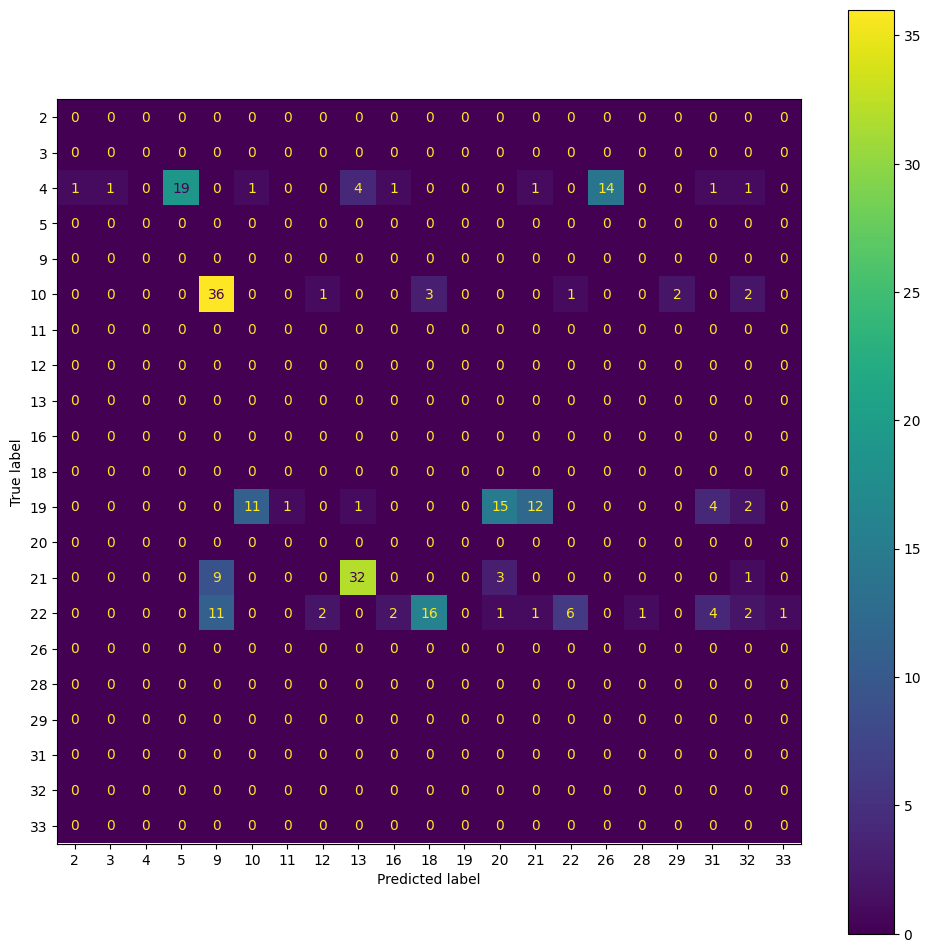

In [ ]:
# Visualize the confusion matrix and compute key classification metrics including
# accuracy, mean F1-score, and F1-score variability across classes.
# -----------------------------

# Set up a large figure for the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))  # Customize size as needed for better readability

# Plot the confusion matrix using true and predicted labels
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, ax=ax)

# Compute classification metrics
accuracy = accuracy_score(true_labels, predictions)                      # Overall accuracy
f1_macro = f1_score(true_labels, predictions, average='macro')           # Unweighted average F1
f1_weighted = f1_score(true_labels, predictions, average='weighted')     # Weighted by class support
f1_scores = f1_score(true_labels, predictions, average=None)             # F1-score for each individual class
std_f1 = np.std(f1_scores)                                               # Variation across classes
mean_f1 = np.mean(f1_scores)                                             # Mean of class-wise F1-scores

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")
print(f"Standard Deviation of F1-Scores: {std_f1:.4f}")

# Show the plotted confusion matrix
plt.show()